In [1]:
import numpy as np
import pandas as pd
import itertools
import pickle
from matplotlib import pyplot as plt
import datetime
from scipy import optimize
import sys
sys.path.append('../SEIR_full/')
sys.path.append('..')
import SEIR_full as mdl
import SEIR_full.model_class as mdl
from PolicyOptimization import EvaluatePolicy as pol
import datetime as dt
from scipy.stats import poisson
from scipy.stats import binom
import copy
import os
import time

In [2]:
with (open('../Data/parameters/indices.pickle', 'rb')) as openfile:
    ind = pickle.load(openfile)

# reconstructing sergey old opt

In [18]:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
    'base',
#     'lb',
]

In [25]:
policy_params = {
    'policy_period': 7,
    'stop_inter': mdl.inter2name(ind, 10),
    'free_inter': mdl.inter2name(ind, 100, no_risk=False),
    'deg_param': None,
    'global_decision': True,
    'max_duration': 2,
    'threshold': 5e2,
}
# [Is, new_Is, H, Vent]
policy_params['weight_matrix'] = np.zeros([4,9])
policy_params['weight_matrix'][3][5:] = 0.25*10

policy_params_list = [policy_params.copy()]
policy_params['global_decision'] = False
policy_params['policy_period'] = 1
policy_params['max_duration'] = 14
policy_params['num_of_regions'] = 40
policy_params_list.append(policy_params)

In [26]:
policy_params_list

[{'policy_period': 7,
  'stop_inter': '250@10',
  'free_inter': '250@100_kid019',
  'deg_param': None,
  'global_decision': True,
  'max_duration': 2,
  'threshold': 500.0,
  'weight_matrix': array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 2.5, 2.5, 2.5, 2.5]])},
 {'policy_period': 1,
  'stop_inter': '250@10',
  'free_inter': '250@100_kid019',
  'deg_param': None,
  'global_decision': False,
  'max_duration': 14,
  'threshold': 500.0,
  'weight_matrix': array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
         [0. , 0. , 0. , 0. , 0. , 2.5, 2.5, 2.5, 2.5]]),
  'num_of_regions': 40}]

In [27]:
scen = 'Scenario2'
start_inter = pd.Timestamp('2020-05-03')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibrattion_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}
res_mdl_glob = []
pol_states = []
for key in cal_parameters.keys():
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[key]['beta_j'],
        theta=cal_parameters[key]['theta'],
        beta_behave=cal_parameters[key]['beta_behave'],
        eps=mdl.eps_sector[scen],
        f=mdl.f0_full[scen],
    )

    model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )

    _, model = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            [mdl.inter2name(ind, 30, no_risk=False,no_kid=False,)],
            sim_length=7, 
            fix_vents=False,
    )
    for policy_params in policy_params_list:
        res_mdl_glob_i, pol_states_i = pol.run_global_policy(
            ind, 
            model, 
            policy_params, 
            1200 - 7 - (start_inter-beginning).days, 
            mdl.pop_israel,
        )
        res_mdl_glob.append(res_mdl_glob_i)
        pol_states.append(pol_states_i)

Recovered cases max:  22.40452814495492
total casulties:  4425.127048185982
Recovered cases max:  37.655084834035385
total casulties:  8457.713604361918


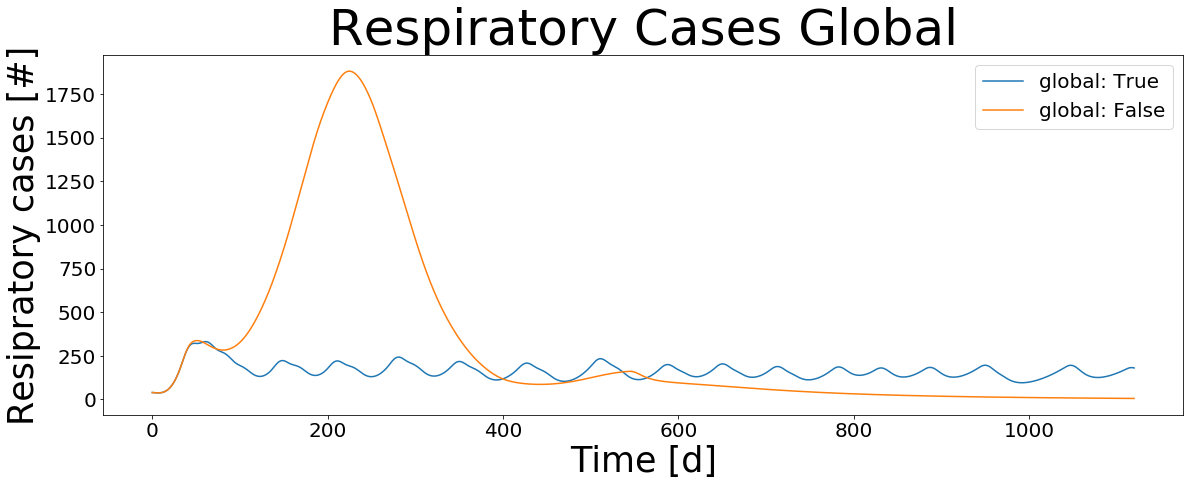

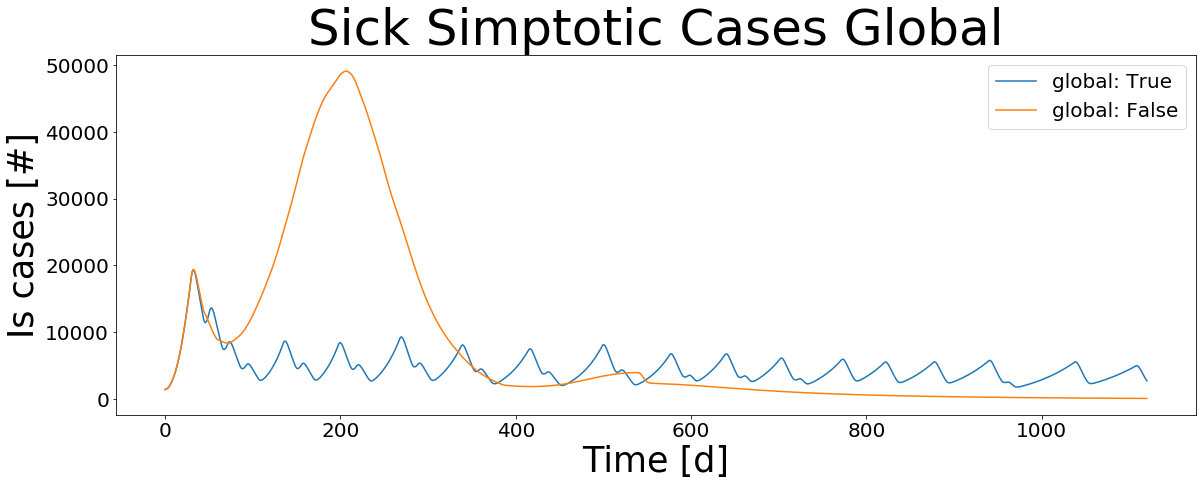

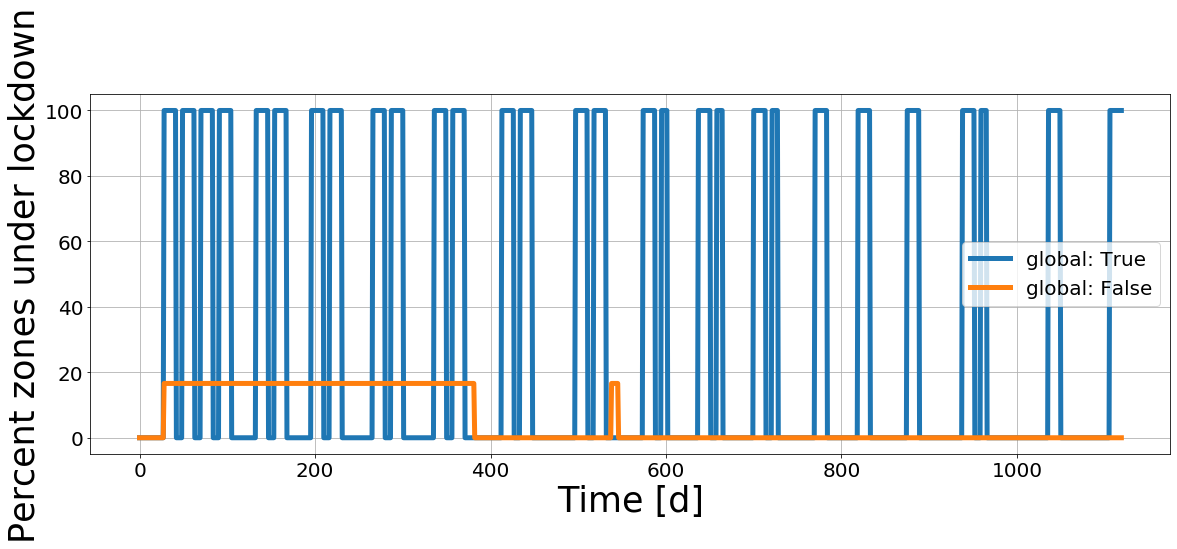

In [28]:
for key in cal_parameters.keys():
    for i in range(len(policy_params_list)):
#         print(policy_params_list[i])
        print('Recovered cases max: ', mdl.make_recoveries(res_mdl_glob[i], -1))
        print('total casulties: ', mdl.make_casulties(res_mdl_glob[i], -1, mdl.pop_israel, model.mu))

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
for key in cal_parameters.keys():
    for i in range(len(policy_params_list)):
        ax.plot(((res_mdl_glob[i]['Vents']).sum(axis=1))[(start_inter-beginning).days+7:]*mdl.pop_israel, label=('global: '+ str(policy_params_list[i]['global_decision'])))
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases Global', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
# ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.legend(fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
for key in cal_parameters.keys():
    for i in range(len(policy_params_list)):
        ax.plot(((res_mdl_glob[i]['Is']).sum(axis=1))[(start_inter-beginning).days+7:]*mdl.pop_israel, label=('global: '+ str(policy_params_list[i]['global_decision'])))
ax.set_ylabel('Is cases [#]', fontsize=35)
ax.set_title('Sick Simptotic Cases Global', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
# ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.legend(fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
for i in range(len(policy_params_list)):
    pol_pct = [100*sum(list(x.values()))/len(x) for x in pol_states[i]]
    ax.plot(pol_pct,linewidth=5, label=('global: '+ str(policy_params_list[i]['global_decision'])))
ax.set_ylabel('Percent zones under lockdown', fontsize=35)
ax.set_xlabel('Time [d]', fontsize=35)
ax.grid('on')
ax.legend(fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()